In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from utils.siglip_experiment import SigLIPExperiment

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiment Showing that Bias Parameterization (instead of Relative Bias) leads to near-zero relative bias

In [6]:

n_classes = 100
dim= 10
initial_temperature  = 10
initial_biases = [-10, -5, 0, 5, 10]
n_epochs = 10000
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'


In [7]:
torch.manual_seed(50)
loss_history_b = []
rbias_history_b = []
temperature_history_b = []
ip_history_b = []
for b in initial_biases:
    experiment = SigLIPExperiment(
        n_classes=n_classes,
        dim=dim,
        n_epochs=n_epochs,
        device=device_str,
        relative_bias_parameterization= False,
        return_t_b_history= True,
        )

    U_final_b, V_final_b, criterion_final, losses, temperatures, relativebiases = experiment.train(
        bias = b,
        temperature=initial_temperature,
        trainable_bias=True,
        trainable_temp=True,
        )

    loss_history_b.append(losses)
    rbias_history_b.append(relativebiases)
    temperature_history_b.append(temperatures)
    ip_history_b.append(U_final_b.cpu().detach().numpy() @ V_final_b.cpu().detach().numpy().T)
print("\n--- Training Complete ---")


--- Training Complete ---


In [8]:
torch.manual_seed(50)
loss_history = []
rbias_history = []
temperature_history = []
ip_history = []
for b in initial_biases:
    experiment = SigLIPExperiment(
        n_classes=n_classes,
        dim=dim,
        n_epochs=n_epochs,
        device=device_str,
        relative_bias_parameterization= True,
        return_t_b_history= True,
        when_to_print = 5000,
        )

    U_final_b, V_final_b, criterion_final, losses, temperatures, relativebiases = experiment.train(
        relative_bias = b/initial_temperature,
        temperature=initial_temperature,
        trainable_bias=True,
        trainable_temp=True
        )

    loss_history.append(losses)
    rbias_history.append(relativebiases)
    temperature_history.append(temperatures)
    ip_history.append(U_final_b.cpu().detach().numpy() @ V_final_b.cpu().detach().numpy().T)
print("\n--- Training Complete ---")

[5000/10000]  loss=0.0001  T=27.3980  rb=0.4297
[10000/10000]  loss=0.0000  T=37.8217  rb=0.5657
[5000/10000]  loss=0.0000  T=33.9863  rb=0.3646
[10000/10000]  loss=0.0000  T=45.4787  rb=0.4434
[5000/10000]  loss=0.0000  T=39.9677  rb=0.4779
[10000/10000]  loss=0.0000  T=51.6039  rb=0.5056
[5000/10000]  loss=0.0000  T=46.6835  rb=0.7435
[10000/10000]  loss=0.0000  T=56.8039  rb=0.7359
[5000/10000]  loss=0.0000  T=41.1736  rb=0.7270
[10000/10000]  loss=0.0000  T=50.9366  rb=0.7188

--- Training Complete ---


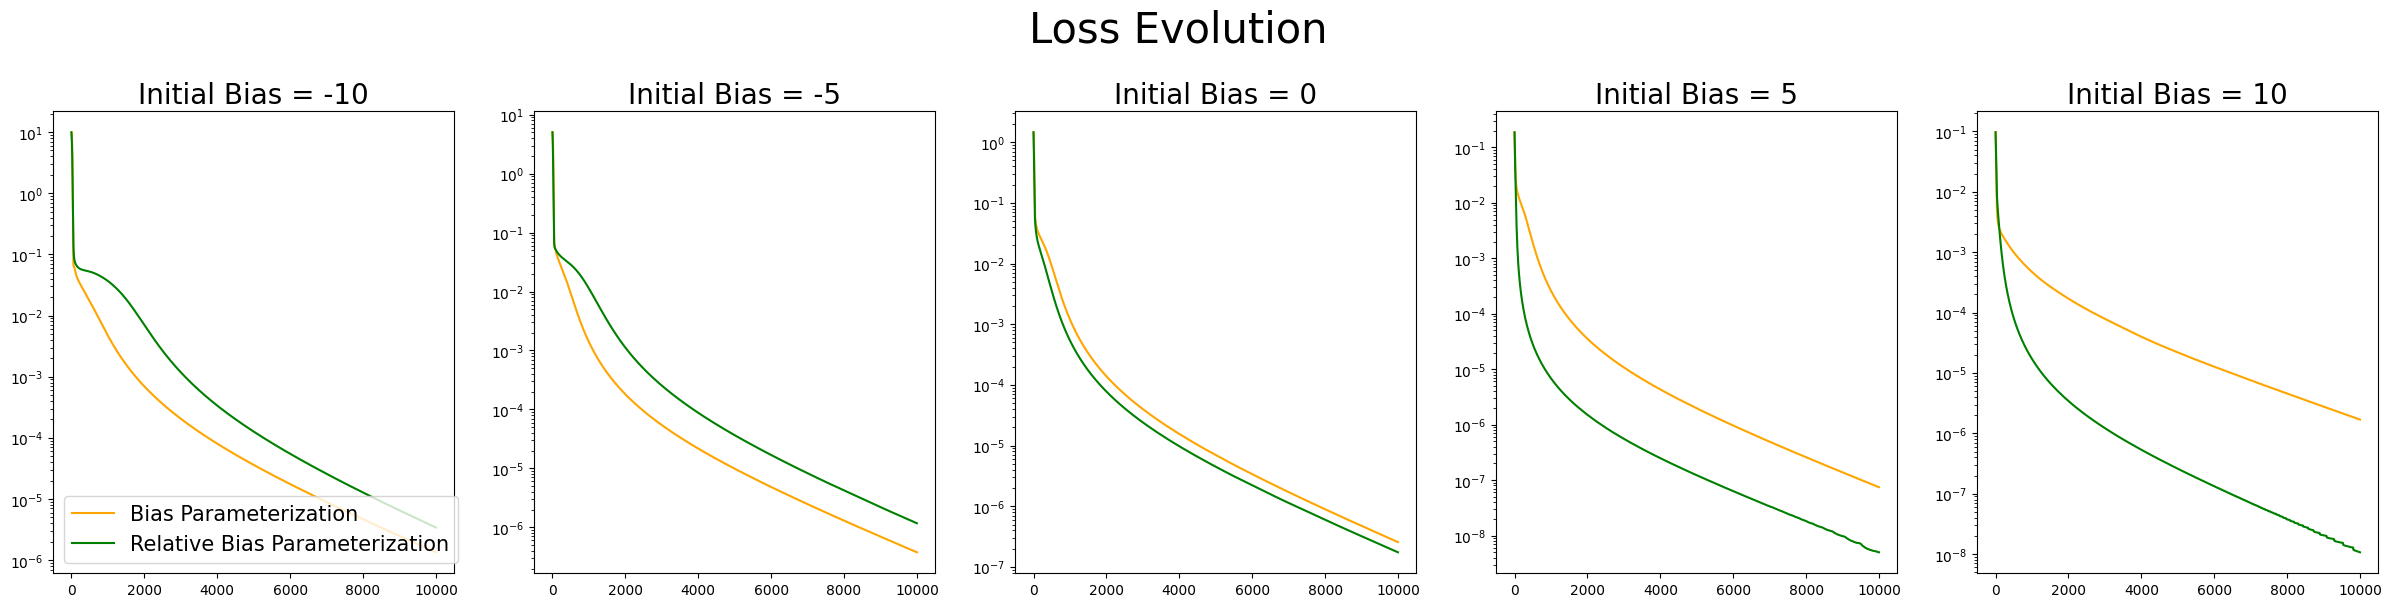

In [11]:
fig = plt.figure(figsize=(30,6))
plt.suptitle("Loss Evolution", fontsize=30, y = 1.05)
iterations = np.arange(n_epochs)
for idx,b in enumerate(initial_biases):
    ax = plt.subplot(1, 5, idx+1)
    ax.plot(iterations,loss_history_b[idx], label = f"Bias Parameterization",color = "orange")
    ax.plot(iterations,loss_history[idx], label = f"Relative Bias Parameterization",color = "green")
    ax.set_title(f"Initial Bias = {b}",fontsize = 20)
    ax.set_yscale("log")
    if idx == 0:
        ax.legend(fontsize = 15, loc = "lower left")
plt.savefig("logs/bisavsrelativebias_losses.png", dpi = 300, bbox_inches = "tight")
plt.show()


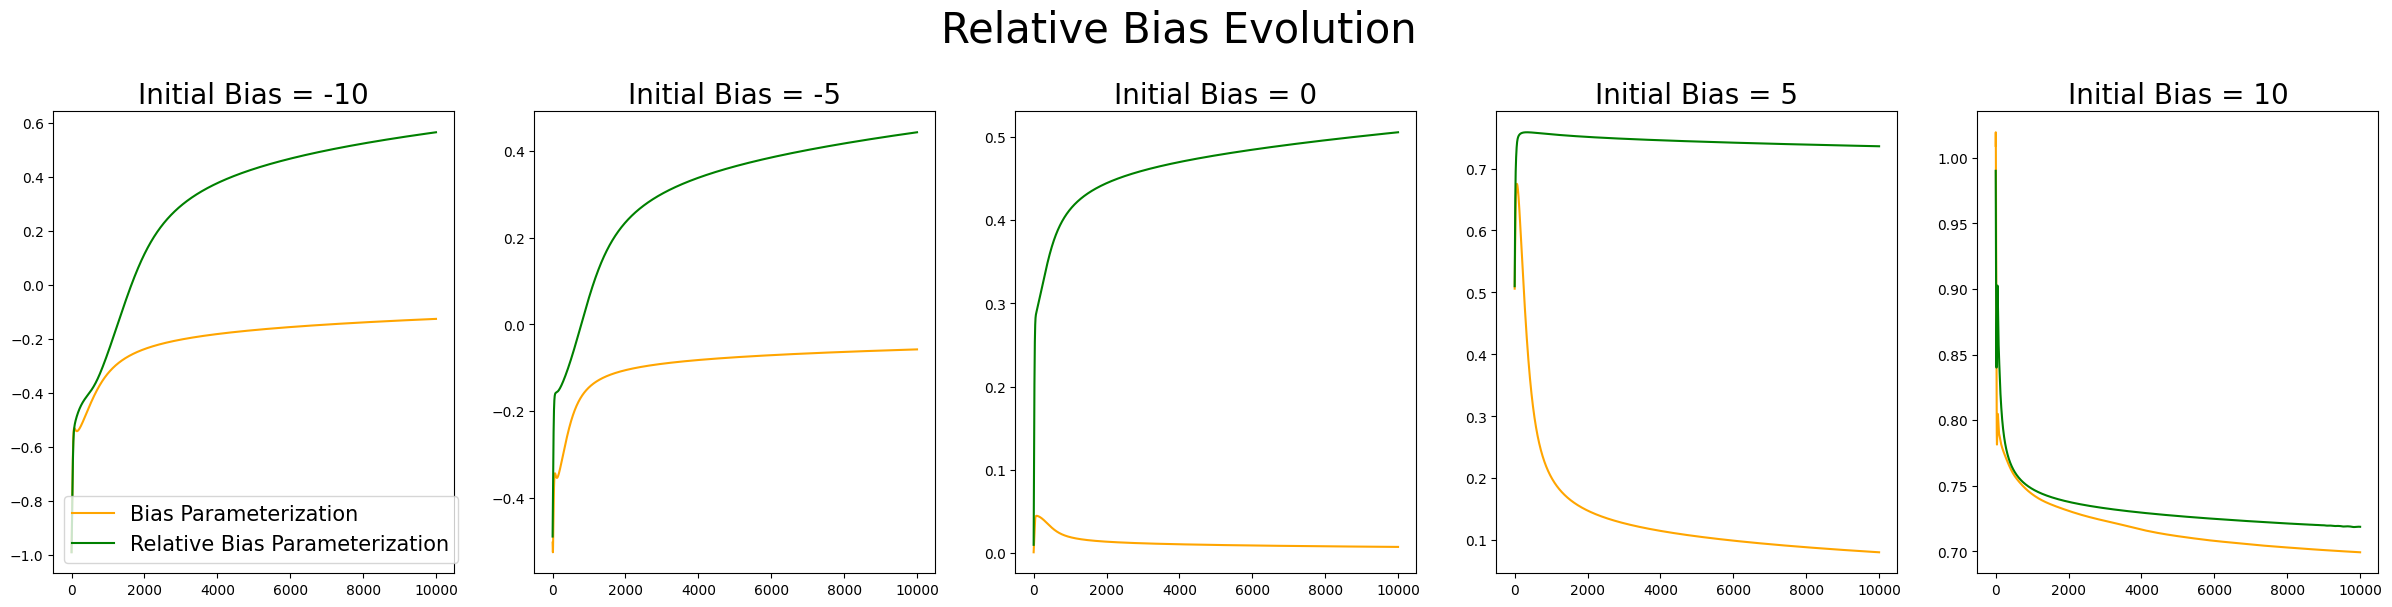

In [12]:
fig = plt.figure(figsize=(30,6))
plt.suptitle("Relative Bias Evolution", fontsize=30, y = 1.05)
iterations = np.arange(n_epochs)
for idx,b in enumerate(initial_biases):
    ax = plt.subplot(1, 5, idx+1)
    ax.plot(iterations,rbias_history_b[idx], label = f"Bias Parameterization",color = "orange")
    ax.plot(iterations,rbias_history[idx], label = f"Relative Bias Parameterization",color = "green")
    ax.set_title(f"\n\nInitial Bias = {b}",fontsize = 20)
    if idx == 0:
        ax.legend(fontsize = 15, loc = "lower left")
plt.savefig("logs/bisavsrelativebias_evolution.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [13]:
margin_b  = [(np.min(np.diag(ip_history_b[i])) - np.max(ip_history_b[i] - 10*np.eye(n_classes)))/2 for i in range(5)]
margin_rb = [(np.min(np.diag(ip_history[i])) - np.max(ip_history[i] - 10*np.eye(n_classes)))/2 for i in range(5)]

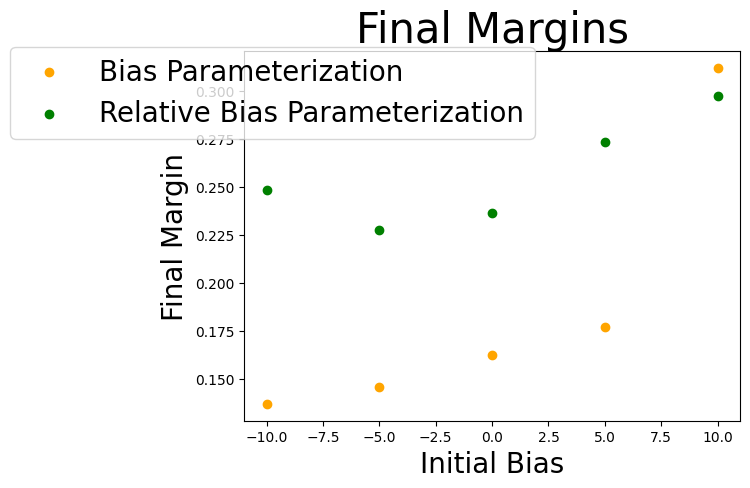

In [ ]:
plt.title("Final Margins", fontsize=30)

plt.scatter(initial_biases,margin_b, label = f"Bias Parameterization",color = "orange")
plt.scatter(initial_biases,margin_rb, label = f"Relative Bias Parameterization",color = "green")
plt.xlabel(f"Initial Bias",fontsize = 20)
plt.ylabel(f"Final Margin", fontsize = 20)
plt.legend(fontsize = 20, loc = "upper left", bbox_to_anchor = (-.5,1.05))
plt.savefig("logs/bisavsrelativebias_margins.png", dpi = 300, bbox_inches = "tight")
plt.show()